# Elastic Response Spectra
#### April 2020, By Amir Hossein Namadchi
This one deals with an elastic SDOF system subjected to the El Centro ground acceleration, $\ddot{d_g}$. The aim is to obtain response spectra for the system with various damping values.

![EPSDOF](imgs/SDOFEQEX.PNG)

In [1]:
import numpy as np
import openseespy.opensees as ops
import matplotlib.pyplot as plt

# Loading El Centro EQ data (North-south component)
el_centro_raw = np.loadtxt('elCentro.txt')

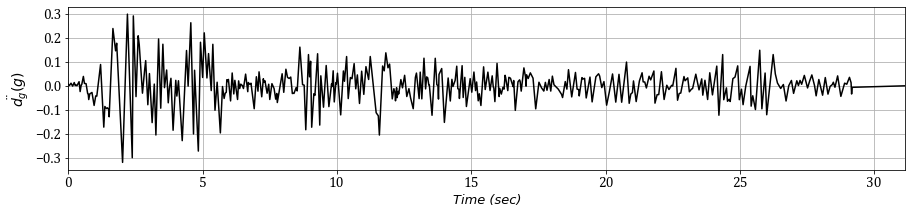

In [2]:
plt.figure(figsize=(15,3))
plt.plot(el_centro_raw[:,0], el_centro_raw[:,1], color='k')

plt.ylabel('$\ddot{d_g} (g)$', {'size':14})
plt.xlabel('Time (sec)', {'fontstyle':'italic','size':13})

plt.grid()
plt.yticks(fontname = 'Cambria', fontsize = 14)
plt.xticks(fontname = 'Cambria', fontsize = 14)
plt.xlim([0.0, el_centro_raw[-1,0]]);

### Analysis

In [3]:
# Define a period range below
T_min = 0.00001
T_max = 5
dT = 0.05
# a list of damping ratios to be included
zeta_list = np.array([0.02, 0.03, 0.05])


# Base units
cm = 1.0
sec = 1.0
# Gravitational constant
g = 981*cm/sec**2

The `analyze_SDOF` function performs numerical time integration of a damped elastic SDOF system subjected to the previously defined base excitation. Then, it returns the absolute maximum of response parameters as a `dict`. It should be reminded that, for a given ground motion, the response parameters of the SDOF system depends only on the natural period and its damping ratio, i.e. $T$ and $\zeta$.

In [4]:
def analyze_SDOF(period, damping_ratio):
    
    # natural frequency
    omega = (2*np.pi)/period
    # stiffness
    k = omega**2
    # Damping
    c = 2*damping_ratio*omega
    
    # Model Definition
    ops.wipe()
    ops.model('basic', '-ndm', 1, '-ndf', 1)
    ops.node(1, 0.0)
    ops.node(2, 0.0)
    ops.uniaxialMaterial('Elastic', 1, k)
    ops.element('zeroLength', 1, *[1, 2], '-mat', 1, '-dir', 1)
    # unit mass is assumed
    ops.mass(2, 1.0)
    ops.rayleigh(c, 0, 0, 0)
    ops.fix(1, 1)

    ## Loading
    dt = 0.02
    ops.timeSeries('Path', 1,
               '-dt', dt,
               '-values', *(el_centro_raw[:,1]*g),
               '-time', *el_centro_raw[:,0])

    ops.pattern('UniformExcitation', 1, 1, '-accel', 1)
    ops.constraints('Transformation')
    ops.numberer('Plain')
    ops.system('ProfileSPD')
    ops.algorithm('Linear', False, False, True)
    ops.integrator('Newmark', 0.5, 0.25)
    ops.analysis('Transient')
        
    results = {'D':[],'V':[], 'A':[]}
    for i in range(len(el_centro_raw)):
        ops.analyze(1, dt)
        results['D'].append(ops.nodeDisp(2, 1))
        results['V'].append(ops.nodeVel(2, 1))
        results['A'].append(ops.nodeAccel(2, 1))    
        
    return {'SD': np.max(np.abs(results['D'])),
            'SV': np.max(np.abs(results['V'])),
            'SA': np.max(np.abs(results['A']))}
    

Here, I use nested loops to analyse the system for various damping ratios and periods.

In [5]:
data_frame = dict()

for z in zeta_list:    
    # re-initialization
    resp = {'T':[0],'SD':[0], 'SV':[0], 'SA':[0]}
    
    for T in np.arange(T_min, T_max, dT):
        SR = analyze_SDOF(T, z)
        resp['SD'].append(SR['SD'])
        resp['SV'].append(SR['SV'])
        resp['SA'].append(SR['SA'])
        resp['T'].append(T)
    
    # Appending keys and values dynamically
    data_frame[z] = resp
    print('Done with zeta=', z,'!')
        

Done with zeta= 0.02 !
Done with zeta= 0.03 !
Done with zeta= 0.05 !


### Visualization

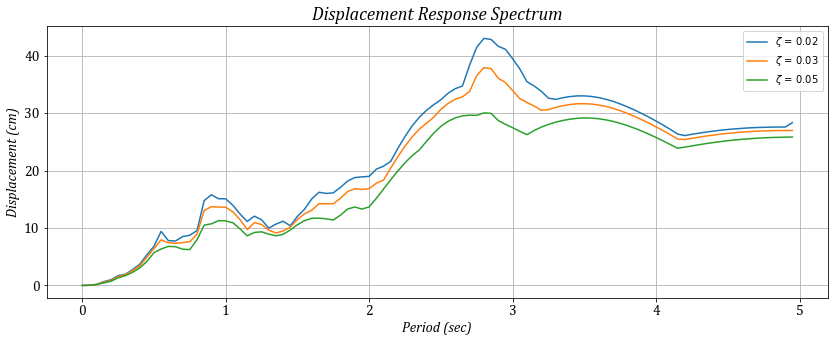

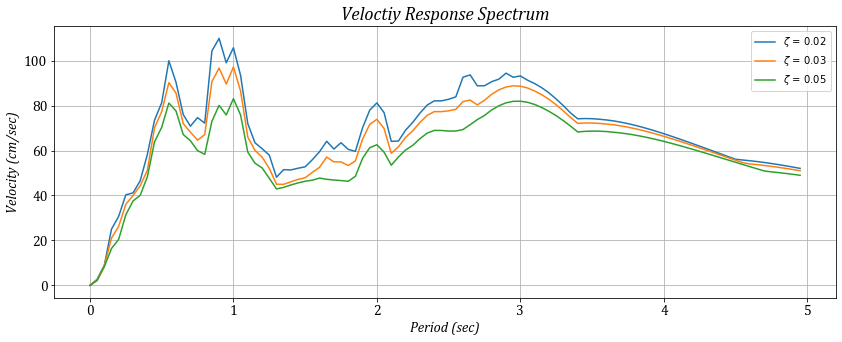

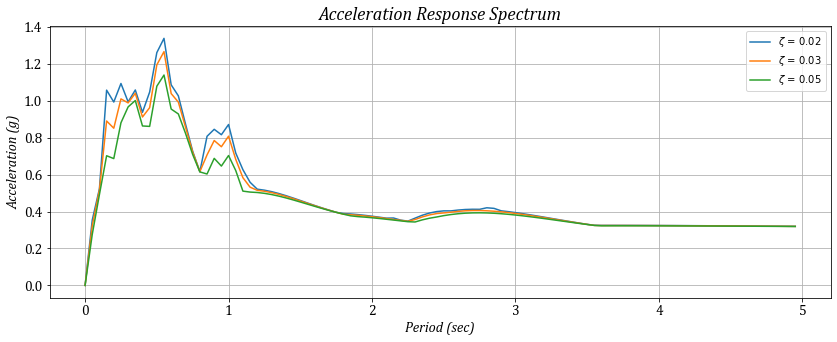

In [6]:
# Displacment -----------
plt.figure(figsize=(14,5))

[plt.plot(data_frame[z]['T'], data_frame[z]['SD'],
          label=('$\zeta$ = '+str(z))) for z in zeta_list]

plt.ylabel('Displacement (cm)', {'fontname':'Cambria',
                                 'fontstyle':'italic','size':14})
plt.xlabel('Period (sec)', {'fontname':'Cambria',
                            'fontstyle':'italic','size':14})
plt.legend()
plt.grid()
plt.yticks(fontname = 'Cambria', fontsize = 14)
plt.xticks(fontname = 'Cambria', fontsize = 14)
plt.title('Displacement Response Spectrum',
          {'fontname':'Cambria',
           'fontstyle':'italic','size':18});

# Velocity ------------
plt.figure(figsize=(14,5))

[plt.plot(data_frame[z]['T'], data_frame[z]['SV'],
          label=('$\zeta$ = '+str(z))) for z in zeta_list]

plt.ylabel('Velocity (cm/sec)', {'fontname':'Cambria',
                                 'fontstyle':'italic','size':14})
plt.xlabel('Period (sec)', {'fontname':'Cambria',
                            'fontstyle':'italic','size':14})
plt.legend()
plt.grid()
plt.yticks(fontname = 'Cambria', fontsize = 14)
plt.xticks(fontname = 'Cambria', fontsize = 14)
plt.title('Veloctiy Response Spectrum', 
          {'fontname':'Cambria', 'fontstyle':'italic','size':18});

# Acceleration ------------
plt.figure(figsize=(14,5))

[plt.plot(data_frame[z]['T'], np.array(data_frame[z]['SA'])/g,
          label=('$\zeta$ = '+str(z))) for z in zeta_list]

plt.ylabel('Acceleration (g)', {'fontname':'Cambria',
                                'fontstyle':'italic','size':14})
plt.xlabel('Period (sec)', {'fontname':'Cambria',
                            'fontstyle':'italic','size':14})
plt.legend()
plt.grid()
plt.yticks(fontname = 'Cambria', fontsize = 14)
plt.xticks(fontname = 'Cambria', fontsize = 14)
plt.title('Acceleration Response Spectrum',
          {'fontname':'Cambria', 'fontstyle':'italic','size':18});

### References
- <blockquote>Chopra, A.K., 2017. Dynamics of structures. theory and applications to. Earthquake Engineering.
</blockquote>